<p style="font-size:14pt;text-align:center;">
Training Fast R-CNN network on PascalVOC 2005.
</p>

In [559]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys

# image processing
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, hsv2rgb

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params, set_all_param_values
import lasagne.layers as layers
import lasagne.objectives as objectives
import lasagne.nonlinearities as nonlinearities
    
import bnr_ml.objectdetect.fastrcnn as fastrcnn
import bnr_ml.utils.helpers as helpers
from bnr_ml.objectdetect.utils import BoundingBox, draw_coord
import bnr_ml.objectdetect.utils as utils

from selectivesearch import selective_search

import pdb

In [2]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.txt', 'rb') as f:
    annotations = pk.load(f)['annotations']

In [3]:
def add_proper_labels(annotations):
    for im in annotations:
        for obj in im:
            if 'car' in obj['label'].lower():
                obj['label'] = 'car'
            elif 'bicycle' in obj['label'].lower():
                obj['label'] = 'bicycle'
            elif 'person' in obj['label'].lower():
                obj['label'] = 'person'
            elif 'motorbike' in obj['label'].lower():
                obj['label'] = 'bike'
            elif 'bike' in obj['label'].lower():
                obj['label'] = 'bicycle'
            else:
                print obj

In [4]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for im in annotations:
        for obj in im:
            if obj['label'] == 0:
                counts[0] += 1
            elif obj['label'] == 1:
                counts[1] += 1
            elif obj['label'] == 2:
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [5]:
def get_num_from_label(obj):
    lab = obj['label'].lower()
    if 'car' == lab:
        obj['label'] = 0
    elif 'bicycle' == lab:
        obj['label'] = 1
    elif 'bike' == lab:
        obj['label'] = 2
    elif 'person' == lab:
        obj['label'] = 3
    else:
        obj['label'] = 4
    return obj

In [6]:
def fix_obj(obj):
    x, y = obj['p1'][0], obj['p1'][1]
    w, h = obj['p2'][0] - x, obj['p2'][1] - y
    obj['x'], obj['y'], obj['w'], obj['h'] = x, y, w, h
    del obj['p1'], obj['p2']
    return get_num_from_label(obj)

In [7]:
add_proper_labels(annotations)

In [8]:
annotations = [[fix_obj(obj) for obj in objs] for objs in annotations]

In [9]:
annotations = np.asarray(annotations)

In [10]:
counts = get_label_counts(annotations)

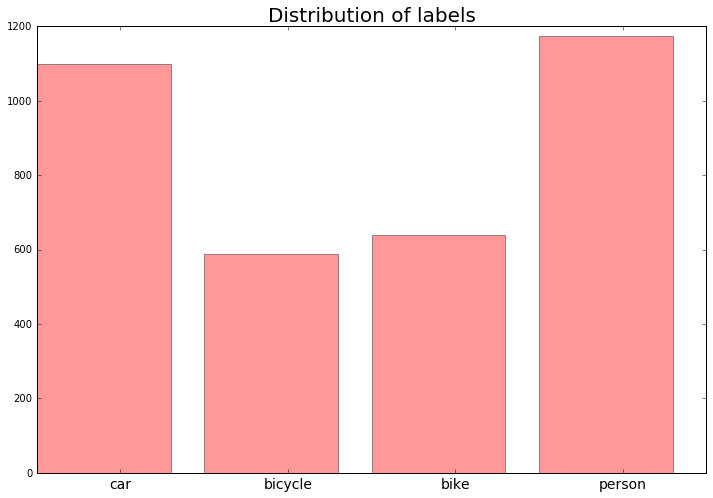

In [11]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [12]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [13]:
with open('indices.pkl', 'rb') as f:
    indices = pk.load(f)
    train_idx = indices['train_index']
    test_idx = indices['test_index']

In [14]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

<b>Fix annotations so that you can use the static method for generating data for fast r-cnn.</b>

<b>Now we define the net for recognition.</b>

In [463]:
num_epochs = 1000
batch_size = 50

In [16]:
num_classes = 4

In [603]:
test_net = True
if test_net:
    gen = test_gen = fastrcnn.FastRCNNDetector.generate_data(test_annotations[:50], input_shape, num_classes, num_rios=1, per_batch=50)
    X,y = [g for g in gen][0]
    X,y = theano.shared(X), theano.shared(y)
    input_var = X
else:
    input_var = None

In [604]:
input_shape = (224,224)
net = {}
net['input'] = InputLayer((None,3) + input_shape, input_var=input_var)
net['conv1'] = Conv2DLayer(net['input'], 16, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv2'] = Conv2DLayer(net['conv1'], 16, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['pool1'] = Pool2DLayer(net['conv2'], (2,2))
net['conv3'] = Conv2DLayer(net['pool1'], 32, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv4'] = Conv2DLayer(net['conv3'], 32, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['pool2'] = Pool2DLayer(net['conv4'], (2,2))
net['conv5'] = Conv2DLayer(net['pool2'], 64, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv6'] = Conv2DLayer(net['conv5'], 64, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv7'] = Conv2DLayer(net['conv6'], 64, (1,1), nonlinearity=nonlinearities.leaky_rectify)
net['pool3'] = Pool2DLayer(net['conv7'], (2,2))
net['conv8'] = Conv2DLayer(net['pool3'], 128, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv9'] = Conv2DLayer(net['conv8'], 128, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv10'] = Conv2DLayer(net['conv9'], 128, (1,1), nonlinearity=nonlinearities.leaky_rectify)
net['pool4'] = Pool2DLayer(net['conv10'], (2,2))
net['conv11'] = Conv2DLayer(net['pool4'], 128, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv12'] = Conv2DLayer(net['conv11'], 128, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv13'] = Conv2DLayer(net['conv12'], 128, (1,1), nonlinearity=nonlinearities.leaky_rectify)


net['dense1'] = DenseLayer(dropout(net['conv13'], p=.5), 2048, nonlinearity=None)
# net['dense2'] = DenseLayer(dropout(net['dense1'], p=.5), 2048)
net['dense2'] = DenseLayer(dropout(net['dense1'], p=.7), (2 * 5 + 4) * (6*6))
net['output'] = DenseLayer(dropout(net['dense2'], p=.5), 5, nonlinearity=lasagne.nonlinearities.softmax)

<b>Load pre-trained weights</b>

In [561]:
load_pretrained = True
if load_pretrained:
    with open('pretrained_weights_2.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Add extra layers to network for detection</b>

In [605]:
net['dense2'] = DenseLayer(dropout(net['dense1'], p=.5), 2048, nonlinearity=None)
net['detect'] = DenseLayer(dropout(net['dense2'], p=.5), 5, nonlinearity=lasagne.nonlinearities.softmax)
net['localize'] = DenseLayer(dropout(net['dense2'], p=.5), (num_classes + 1) * 4)

In [606]:
load_weights = True
if load_weights:
    with open('fastrcnn_weights.pkl', 'rb') as f:
        params = pk.load(f)
        tmp = params[:-4]
        tmp.extend(params[-2:])
        set_all_param_values(net['detect'], params[:-2])
        set_all_param_values(net['localize'], tmp)

<b>Train the network

In [607]:
reload(fastrcnn)

<module 'bnr_ml.objectdetect.fastrcnn' from '/usr/local/python/bnr_ml/objectdetect/fastrcnn.pyc'>

In [ ]:
detector = fastrcnn.FastRCNNDetector(net, num_classes)

In [ ]:
cost = detector._get_cost(detector._detect_test, detector._localize_test, y)

> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(70)_get_cost()
-> return T.mean(cost)
(Pdb) target.eval()
CudaNdarray([[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00]
 [ -7.04189995e-03  -6.37519509e-02  -5.98470688e+00   1.13717878e+00
    1.00

In [566]:
print_obj = helpers.NotebookPrinter(open('/dev/stdout', 'w'), sys.stdout)

In [ ]:
train_gen = fastrcnn.FastRCNNDetector.generate_data(train_annotations[:1000], input_shape, num_classes, num_rios=25, per_batch=2)
test_gen = fastrcnn.FastRCNNDetector.generate_data(test_annotations, input_shape, num_classes, num_rios=1, per_batch=50)
train_loss, test_loss = detector.train(
    train_gen,
    test_gen,
    print_obj,
    lr=1e-5,
    lmbda=1.,
    epochs=num_epochs
)

Getting cost...
Compiling...


In [475]:
concat_losses = True
if concat_losses:
    train_loss_total, test_loss_total = train_loss, test_loss
else:
    train_loss_total = np.concatenate((train_loss_total, train_loss))
    test_loss_total = np.concatenate((test_loss_total, test_loss))

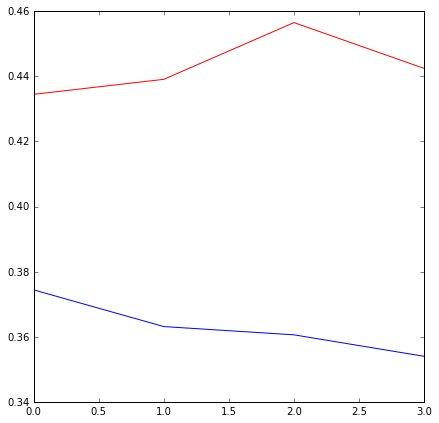

In [476]:
plt.figure(figsize=(7,7))
plt.plot(train_loss, 'b')
plt.plot(test_loss, 'r')

plt.show()

In [568]:
with open('fastrcnn_weights.pkl', 'wb') as f:
    params = [p.get_value() for p in detector.params]
    pk.dump(params, f)

In [478]:
def trans_regions(regions):
    regs = np.zeros((regions.__len__(), 4))
    for i in range(regions.__len__()):
        regs[i] = regions[i]['rect']
    return regs

In [479]:
def num2label(num):
    if num == 0:
        return 'car'
    if num == 1:
        return 'bicycle'
    if num == 2:
        return 'bike'
    if num == 3:
        return 'person'
    else:
        return nothing

In [548]:
im = imread(test_annotations[232][0]['image'])

In [549]:
regions = selective_search(im, scale=500, sigma=0.9, min_size=400)

In [550]:
regions = trans_regions(regions[1])
print regions.shape

(505, 4)


In [551]:
class_score, coord = detector.detect(im, proposals=regions[:50], thresh=.8)
print coord.shape
preds = np.concatenate((coord, np.max(class_score, axis=1, keepdims=True), \
                        np.argmax(class_score, axis=1).reshape((-1,1))), axis=1)

(1, 4)


In [552]:
print coord

[[ 0.          0.          0.99843752  0.99791664]]


In [553]:
reload(utils)

<module 'bnr_ml.objectdetect.utils' from '/usr/local/python/bnr_ml/objectdetect/utils.pyc'>

In [554]:
im_draw = utils.draw_coord(im, preds[:], label_map=num2label)

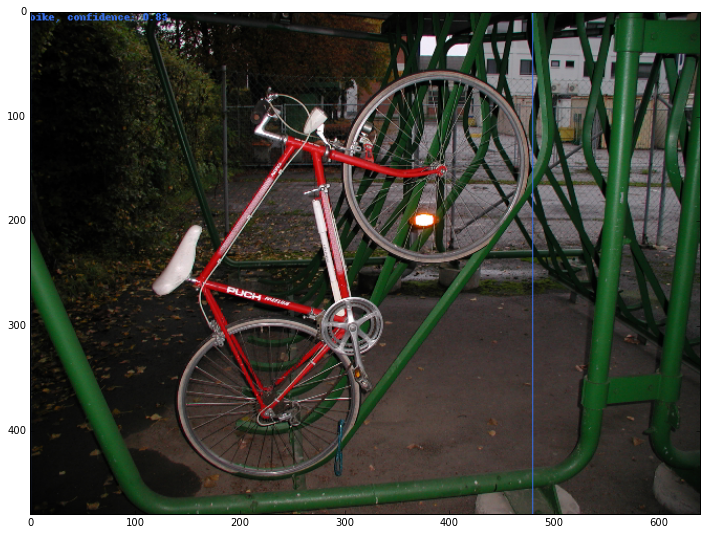

In [555]:
plt.figure(figsize=(12,12))
plt.imshow(im_draw)